In [125]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats.stats import pearsonr
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import seaborn as sns
sns.set_style()
sns.set_context("talk")
import warnings
warnings.filterwarnings("ignore")

In [42]:
# Load the business json file
business_path = 'yelp_dataset/yelp_academic_dataset_business.json'
business = pd.read_json(business_path,lines=True)

In [43]:
# Check the fields in business
business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None


In [44]:
# Dropping businesses which are not open
business = business.loc[business['is_open']==1]

In [47]:
# Check the top 10 cities represented in our dataset
business["city"].value_counts()[:10]

Las Vegas     25043
Phoenix       16305
Toronto       14962
Charlotte      8500
Scottsdale     7341
Calgary        6772
Pittsburgh     6107
Mesa           5482
Montréal       5367
Henderson      4293
Name: city, dtype: int64

In [48]:
# To restrict and limit the size of data, let us stick to Las Vegas only
business = business.loc[business['city'] == 'Las Vegas']

In [49]:
business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
6,oiAlXZPIFm2nBCt0DHLu_Q,Green World Cleaners,"6870 S Rainbow Blvd, Ste 117",Las Vegas,NV,89118,36.063977,-115.241463,3.5,81,1,"{'BusinessParking': '{'garage': False, 'street...","Dry Cleaning & Laundry, Local Services, Laundr...","{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ..."
51,5XMKDYmMGSKkCkrYoELxzg,Annette Thomas Hair Colorist Specialist,"101 S Rainbow Blvd, Ste 23, Darby's Hairitage",Las Vegas,NV,89107,36.172534,-115.244762,5.0,7,1,"{'GoodForKids': 'True', 'BusinessParking': '{'...","Hair Stylists, Hair Salons, Beauty & Spas",None


In [ ]:
# Drop the columns that we dont need
business = business.drop(['city','address', 'state', 'latitude', 'longitude', 'is_open','attributes','hours'], axis=1)

In [51]:
# Restricting to businesses with atleast 10 reviews
business = business.loc[business['review_count'] >= 10]

In [55]:
# Check the number of businesses we have in our datset now
business.shape

(15386, 6)

In [57]:
# Check the dataset
business.head(5)

,business_id,name,postal_code,stars,review_count,categories
6,oiAlXZPIFm2nBCt0DHLu_Q,Green World Cleaners,89118,3.5,81,"Dry Cleaning & Laundry, Local Services, Laundr..."
66,bierVTEi44nJtFVQ01N-yQ,Lacoste Outlet Las Vegas,89106,3.5,11,"Accessories, Shopping, Fashion, Men's Clothing..."
78,FrMRHhzT-qUzv1-Nh1IOjQ,Sin City Party Buses,89118,4.0,18,"Hotels & Travel, Party Bus Rentals, Limos, Eve..."
86,OWkS1FXNJbozn-qPg3LWxg,Mama Napoli Pizza,89109,4.5,11,"Food, Food Trucks, Restaurants, Pizza"
101,MTx-Zdl_KcU_z9G832XAjg,Taco Bell,89131,2.5,37,"Fast Food, Restaurants"


In [58]:
# Importing review json file in chunks, because of the super large size
review_json_path = 'yelp_dataset/yelp_academic_dataset_review.json'
size = 1000000
review = pd.read_json(review_json_path, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,'text':str,'useful':int},
                      chunksize=size)

In [59]:
review

In [61]:
# With help from: 
#https://towardsdatascience.com/converting-yelp-dataset-to-csv-using-pandas-2a4c8f03bd88

chunk_list = []
for chunk_review in review:
    # Renaming column name to avoid conflict with business overall star rating
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    # Inner merge with edited business file so only reviews related to the business remain
    chunk_merged = pd.merge(business, chunk_review, on='business_id', how='inner')
    # Show feedback on progress
    print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
    chunk_list.append(chunk_merged)
# After trimming down the review file, concatenate all relevant data back to one dataframe
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

252109 out of 1,000,000 related reviews
263049 out of 1,000,000 related reviews
247140 out of 1,000,000 related reviews
257721 out of 1,000,000 related reviews
260832 out of 1,000,000 related reviews
242292 out of 1,000,000 related reviews
253039 out of 1,000,000 related reviews
5745 out of 1,000,000 related reviews


In [65]:
# df is our new dataset with data about restaurants and their corresponding reviews
df.head(5)

,business_id,name,postal_code,stars,review_count,categories,review_id,user_id,review_stars,useful,funny,cool,text,date
0,N1cVo_4pw2iMyi-P5Ih48A,Veer Towers,89158,4.0,26,"Home Services, Real Estate Services, Apartment...",fanKQwFfG-9TZCpc4IZyxg,uNxXIIFzjHm5r62UTyVjrQ,4,4,1,0,I didnt even know this place existed until I g...,2013-04-21 20:45:51
1,N1cVo_4pw2iMyi-P5Ih48A,Veer Towers,89158,4.0,26,"Home Services, Real Estate Services, Apartment...",Xy-vo1ZqV7-FnEO71IFUiQ,pC-VljE3MKlFG1iPavUr1Q,5,4,1,1,Lived here for about 2 years now. Amazing view...,2016-10-09 20:48:15
2,N1cVo_4pw2iMyi-P5Ih48A,Veer Towers,89158,4.0,26,"Home Services, Real Estate Services, Apartment...",4S8TIIrKxETQy6LKZsFjSg,_-jHqPqzIgbFPYGTwTTQ8Q,5,0,1,0,MGM Mirage has begun closing sales at Veer Tow...,2010-09-26 03:45:27
3,N1cVo_4pw2iMyi-P5Ih48A,Veer Towers,89158,4.0,26,"Home Services, Real Estate Services, Apartment...",4cwcSBJmLn54e2F11RWlHw,LapuXd4UMgjP2yzJrAmJzw,4,6,1,3,Simple steel concrete and glass design through...,2011-01-05 19:30:59
4,N1cVo_4pw2iMyi-P5Ih48A,Veer Towers,89158,4.0,26,"Home Services, Real Estate Services, Apartment...",Zes9yxgmB-4NLtbqg4D7EA,KzEHXFjbayCxD12DR8ficA,3,4,2,0,I have visited here several times and the staf...,2013-03-10 03:03:20


In [ ]:
# Dropping columns not required
df.drop(['funny', 'cool','date'], axis=1, inplace = True)

In [69]:
df.head(5)

,business_id,name,postal_code,stars,review_count,categories,review_id,user_id,review_stars,useful,text
0,N1cVo_4pw2iMyi-P5Ih48A,Veer Towers,89158,4.0,26,"Home Services, Real Estate Services, Apartment...",fanKQwFfG-9TZCpc4IZyxg,uNxXIIFzjHm5r62UTyVjrQ,4,4,I didnt even know this place existed until I g...
1,N1cVo_4pw2iMyi-P5Ih48A,Veer Towers,89158,4.0,26,"Home Services, Real Estate Services, Apartment...",Xy-vo1ZqV7-FnEO71IFUiQ,pC-VljE3MKlFG1iPavUr1Q,5,4,Lived here for about 2 years now. Amazing view...
2,N1cVo_4pw2iMyi-P5Ih48A,Veer Towers,89158,4.0,26,"Home Services, Real Estate Services, Apartment...",4S8TIIrKxETQy6LKZsFjSg,_-jHqPqzIgbFPYGTwTTQ8Q,5,0,MGM Mirage has begun closing sales at Veer Tow...
3,N1cVo_4pw2iMyi-P5Ih48A,Veer Towers,89158,4.0,26,"Home Services, Real Estate Services, Apartment...",4cwcSBJmLn54e2F11RWlHw,LapuXd4UMgjP2yzJrAmJzw,4,6,Simple steel concrete and glass design through...
4,N1cVo_4pw2iMyi-P5Ih48A,Veer Towers,89158,4.0,26,"Home Services, Real Estate Services, Apartment...",Zes9yxgmB-4NLtbqg4D7EA,KzEHXFjbayCxD12DR8ficA,3,4,I have visited here several times and the staf...


In [73]:
# Checking number of rows our dataframe has
df.shape

(1781927, 11)

In [76]:
# We can drop reviews which did not recieve any useful votes, to restrict our data further
df = df.loc[df['useful'] > 0]

In [126]:
# Create columns to store lenght of reviews written
df['reviewlen'] = df['text'].str.len()

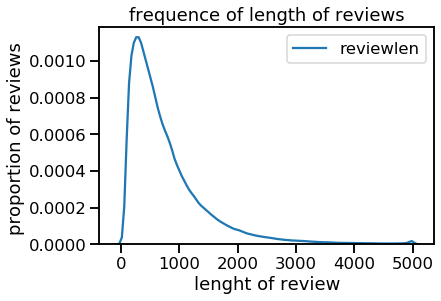

In [150]:
# Visualizing distribution of lenght of reviews
sns.kdeplot(df['reviewlen'])
plt.title('frequence of length of reviews')
plt.xlabel("lenght of review")
plt.ylabel("proportion of reviews ");

In [151]:
# We can restrict our analysis to reviews with length less than 1000
df = df.loc[df['reviewlen'] < 1000]

In [152]:
df.shape

(577300, 12)

In [153]:
# Save data to CSV file for future use
csv_name = "review_and_business_data_cleaned.csv"
df.to_csv(csv_name, index=False)